# Simple convolutional neural network to perform classification.


The project focuses on developing and comparing image classification models using convolutional neural networks (CNNs). First, we build a custom CNN model from scratch, train it on a chosen dataset, and evaluate its performance. Next, we fine-tune two pre-trained state-of-the-art models, such as ResNet or AlexNet, and compare their performance with our custom model.

The goal of this is to understand the trade-offs between designing a CNN from scratch and using pre-trained models through transfer learning. From this we get a chance to explore key concepts like network architecture, activation functions, optimizers, and overfitting, while analyzing how different models handle image classification tasks.

### 1.Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


### 2.Loading the Dataset using ucimlrepo

Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


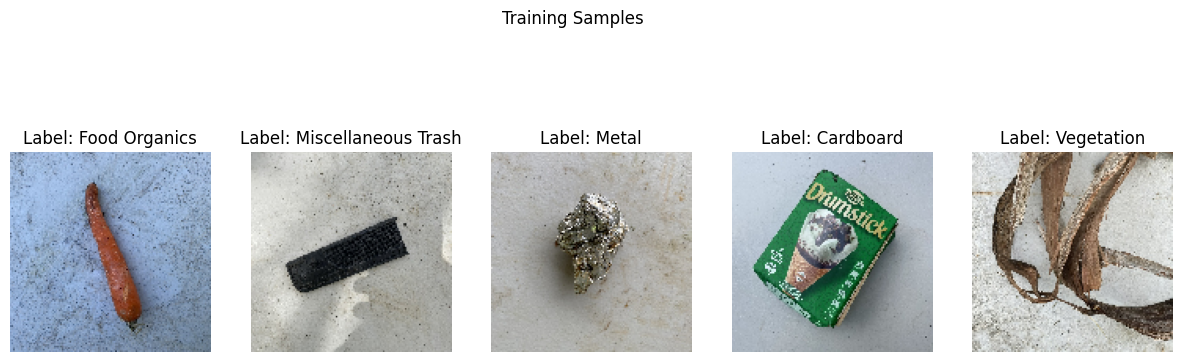

In [13]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the main RealWaste directory
dataset_path = r'C:\Users\prave\Downloads\realwaste\realwaste-main\RealWaste'

# Create ImageDataGenerators for training and validation with a split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data with 80% split
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training'  # Use training split
)

# Load validation data with 20% split
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation'  # Use validation split
)

# Get class names from the training data generator
class_names = list(train_data.class_indices.keys())

# Function to plot a few samples with their labels
def plot_samples(data_gen, class_names, num_samples=5):
    images, labels = next(data_gen)  # Fetch a batch of images and labels
    plt.figure(figsize=(15, 5))
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])]}")
        plt.axis('off')

# Plot training samples
plot_samples(train_data, class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()


### 3.Preprocessing the Data

In [14]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the Sequential model for the RealWaste dataset
model = keras.Sequential([
    # Input layer with input shape matching the size of the resized images (128x128 RGB)
    layers.Flatten(input_shape=(128, 128, 3)),  # 128x128 image with 3 color channels (RGB)

    # Fully connected layers with ReLU activation
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer with units matching the number of classes in the dataset (9 classes)
    layers.Dense(9, activation='softmax')
])

# Set learning rate
learning_rate = 0.0005

# Compile the model using Adam optimizer and sparse categorical crossentropy loss
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


c:\Users\prave\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,624,905 (48.16 MB)

 Trainable params: 12,624,905 (48.16 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Adjust the number of epochs based on your dataset size and training time
)


c:\Users\prave\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.1551 - loss: 4.8310 - val_accuracy: 0.2403 - val_loss: 2.2477
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - accuracy: 0.2761 - loss: 2.1752 - val_accuracy: 0.2592 - val_loss: 2.1138
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accuracy: 0.3210 - loss: 2.0116 - val_accuracy: 0.2497 - val_loss: 2.1102
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 47s 394ms/step - accuracy: 0.3238 - loss: 1.9259 - val_accuracy: 0.2803 - val_loss: 2.1015
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.3711 - loss: 1.7736 - val_accuracy: 0.2360 - val_loss: 2.3343
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.3756 - loss: 1.7722 - val_accuracy: 0.2792 - val_loss: 2.1778
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.3903 - loss: 1.7260 - val_accuracy: 0.2761 - val_loss: 2.0334
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 342ms/step - accuracy: 0.4193 - loss: 1